<a href="https://colab.research.google.com/github/maskot1977/PythonCourse2019/blob/master/kumantic4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
def draw_bear(n_bear=1): # ランダムにクマの足跡画像を生成する
    r = g = b = 250
    im = Image.new('RGB', (400, 400), (r, g, b))
    draw = ImageDraw.Draw(im)

    for _ in range(random.randint(-1, 0)):
        r = random.randint(10, 200)
        g = random.randint(10, 200)
        b = random.randint(10, 200)
        x1 = random.randint(0, 400)
        y1 = random.randint(0, 400)
        dx = random.randint(10, 50)
        dy = random.randint(10, 50)
        draw.ellipse((x1, y1, x1+dx, y1+dy), fill=(r, g, b))

    for _ in range(n_bear):
        r = g = b = 1
        center_x = 200
        center_y = 200
        wx = 60
        wy = 50
        dx1 = 90
        dx2 = 20
        dy1 = 90
        dy2 = 20
        dx3 = 15
        dy3 = 100
        dy4 = 60
        shape1 = (center_x - wx, center_y - wy, center_x + wx, center_y + wy)
        shape2 = (center_x - dx1, center_y - dy1, center_x - dx2, center_y - dy2)
        shape3 = (center_x + dx2, center_y - dy1, center_x + dx1, center_y - dy2)
        shape4 = (center_x - dx3, center_y - dy3, center_x + dx3, center_y - dy4)

        zoom = 0.2 + random.random() * 0.4
        center_x = random.randint(-30, 250)
        center_y = random.randint(-30, 250)

        shape1 = modify(shape1, zoom=zoom, center_x=center_x, center_y=center_y)
        shape2= modify(shape2, zoom=zoom, center_x=center_x, center_y=center_y)
        shape3 = modify(shape3, zoom=zoom, center_x=center_x, center_y=center_y)
        shape4 = modify(shape4, zoom=zoom, center_x=center_x, center_y=center_y)

        draw.ellipse(shape1, fill=(r, g, b))
        draw.ellipse(shape2, fill=(r, g, b))
        draw.ellipse(shape3, fill=(r, g, b))
        #draw.ellipse(shape4, fill=(r, g, b))

    return im

In [0]:
def modify(shape, zoom=1, center_x=0, center_y=0):
    x1, y1, x2, y2 = np.array(shape) * zoom
    return (x1 + center_x, y1 + center_y, x2 + center_x, y2 + center_y)

In [0]:
from PIL import Image, ImageDraw
from itertools import product

class Noise: # クマの足跡画像にノイズを乗せる
    def __init__(self, input_image):
        self.input_image = input_image
        self.input_pix = self.input_image.load()
        self.w, self.h = self.input_image.size

    def saltpepper(self, salt=0.05, pepper=0.05):
        output_image = Image.new("RGB", self.input_image.size)
        output_pix = output_image.load()

        for x, y in product(*map(range, (self.w, self.h))):
            r = random.random()
            if r < salt:
                output_pix[x, y] = (255, 255, 255)
            elif r > 1 - pepper:
                output_pix[x, y] = (  0,   0,   0)
            else:
                output_pix[x, y] = self.input_pix[x, y]
        return output_image

In [0]:
from PIL import ImageFilter
import numpy as np

# クマ足跡画像をセマンティック・セグメンテーション用の教師データに加工する
def getdata_for_semantic_segmentation(im): 
    x_im = im.filter(ImageFilter.CONTOUR)
    im2 = Noise(input_image=x_im)
    x_im = im2.saltpepper()
    a_im = np.asarray(im)
    y_im = Image.fromarray(np.where(a_im == 1, 255, 0).astype(dtype='uint8'))
    return x_im, y_im

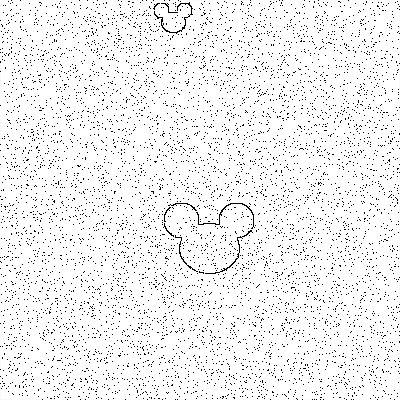

In [7]:
x_im, y_im = getdata_for_semantic_segmentation(draw_bear(n_bear=random.randint(0, 5)))
x_im

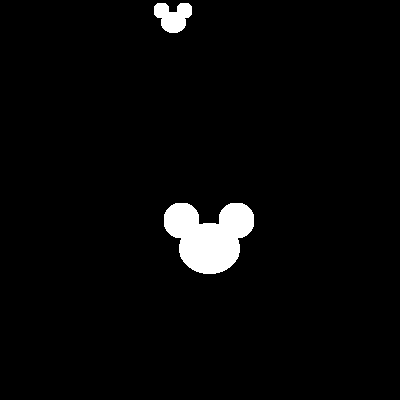

In [8]:
y_im

In [0]:
import torch
from torch import nn, optim
from torch.nn import functional as F
class Kuma(nn.Module):
    def __init__(self):
        super(Kuma, self).__init__()
        # エンコーダー部分
        self.encode1 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 1, out_channels = 6, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(6)
              ])
        self.encode2 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 6, out_channels = 16, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(16)
              ])
        self.encode3 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(32)
              ])

        # デコーダー部分
        self.decode3 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(16)
              ])
        self.decode2 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 16, out_channels = 6, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(6)
              ])
        self.decode1 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 6, out_channels = 1, kernel_size = 3, padding = 1),
              ])

    def forward(self, x):
        # エンコーダー部分
        dim_0 = x.size() # デコーダー第１層でサイズを元に戻すとき用             
        x = F.relu(self.encode1(x))
        # return_indices = True にして、デコーダーで max_pool の位置idxを用いる
        x, idx_1 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        dim_1 = x.size() # デコーダー第２層でサイズを元に戻すとき用
        x = F.relu(self.encode2(x))
        # return_indices = True にして、デコーダーで max_pool の位置idxを用いる                       
        x, idx_2 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)            
        dim_2 = x.size()
        x = F.relu(self.encode3(x)) # デコーダー第３層でサイズを元に戻すとき用
        # return_indices = True にして、デコーダーで max_pool の位置idxを用いる
        x, idx_3 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)

        # デコーダー部分
        x = F.max_unpool2d(x, idx_3, kernel_size = 2, stride = 2, output_size = dim_2)
        x = F.relu(self.decode3(x))
        x = F.max_unpool2d(x, idx_2, kernel_size = 2, stride = 2, output_size = dim_1)           
        x = F.relu(self.decode2(x))                           
        x = F.max_unpool2d(x, idx_1, kernel_size = 2, stride = 2, output_size = dim_0)           
        x = F.relu(self.decode1(x))                           
        x = torch.sigmoid(x)                                     

        return x

In [15]:
kuma = Kuma()
kuma.load_state_dict(torch.load("kuma_100_20200225.pytorch"))

<All keys matched successfully>

In [0]:
X_test = [] # テスト用の画像データを格納
Y_test = [] # テスト用の正解データを格納
Z_test = [] # テスト用の予測結果を格納

for i in range(100): # 学習に用いなかった新規データを１００個生成
    x_im, y_im = getdata_for_semantic_segmentation(draw_bear(n_bear=random.randint(0, 5)))
    X_test.append(x_im)
    Y_test.append(y_im)

In [0]:
# テスト用の画像データをPyTorch用に整形
X_test_a = np.array([[np.asarray(x).transpose((2, 0, 1))[0]] for x in X_test])
X_test_t = torch.tensor(X_test_a, dtype = torch.float32)

# 学習済みのモデルを使って予測値を計算
Y_pred = kuma(X_test_t)

# 予測値を ndarray として格納
for pred in Y_pred:
    Z_test.append(pred.detach().numpy())

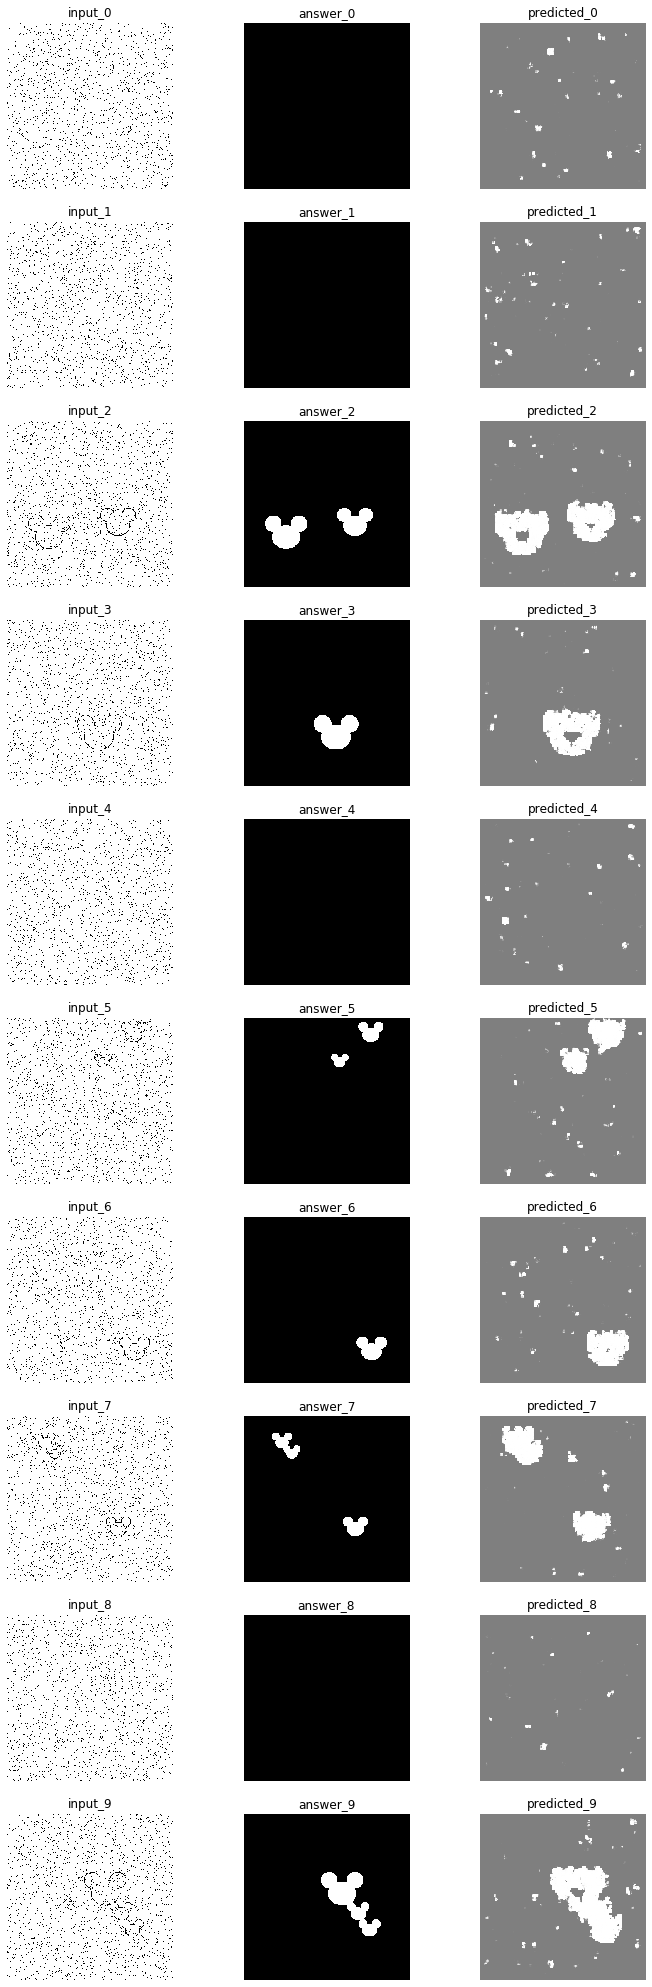

In [19]:
# データの先頭１０個に対して、画像データ、正解データ、予測値を描画
fig = plt.figure(figsize=(12,36))
for i in range(10):
    ax = fig.add_subplot(10, 3, (i * 3)+1)
    ax.axis('off')
    ax.set_title('input_{}'.format(i))
    ax.imshow(X_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+2)
    ax.axis('off')
    ax.set_title('answer_{}'.format(i))
    ax.imshow(Y_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+3)
    ax.axis('off')
    ax.set_title('predicted_{}'.format(i))
    yp2 = Y_pred[i].detach().numpy()[0] * 255
    z_im = Image.fromarray(np.array([yp2, yp2, yp2]).transpose((1, 2, 0)).astype(dtype='uint8'))
    ax.imshow(z_im)
plt.show()

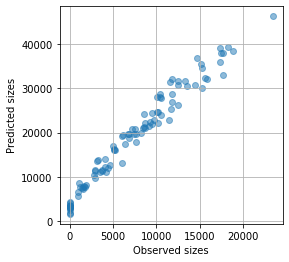

In [20]:
A_ans = []
A_pred = []
for yt, zt in zip(Y_test, Z_test):
    # 正解の白の面積（ベクトルが３色分あるので３で割る）
    A_ans.append(np.where(np.asarray(yt) > 0.5, 1, 0).sum() / 3) 
    A_pred.append(np.where(np.asarray(zt) > 0.5, 1, 0).sum()) # 予測値の白の面積

plt.figure(figsize=(4, 4))
plt.scatter(A_ans, A_pred, alpha=0.5)
plt.grid()
plt.xlabel('Observed sizes')
plt.ylabel('Predicted sizes')
#plt.xlim([0, 1700])
#plt.ylim([0, 1700])
plt.show()